# Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('FDOT_data.csv')
#df

<ipython-input-48-9ec974cee99e>:4: DtypeWarning: Columns (66,78,92,103,362,363,415,471,472,474,475,477,479,483,484,487,489,490,491,492,493,494,495,496,497,498,499,500,501,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('FDOT_data.csv')


In [ ]:
# pulling the wanted columns

predictors = ['CYCLE', 'NEWYR', 'DEFREAS', 'ESALS', 'PAVEMENT TYPE',
              'MAXSPEED', 'SURFTYPE', 'YR', 'SURF2023', 'FCLASS', 'FC',
              'DEFAGE', 'DEFYR', 'FIRSTYRCRK65']
identifiers = ['RDWYID','RDWY', 'BMP', 'EMP', 'CONTYDOT', 'LANES', 'LEN', 'LM', 'DISTRICT']
df_typeyr = df.loc[:, 'TYPE1976':'TYPE2023']
df_crkratings = df.loc [:, 'CRK1976':'CRK2023']

df_filtered = pd.concat([df[identifiers + predictors], df_typeyr, df_crkratings], axis=1)


In [ ]:
df_filtered
df_filtered.to_csv('filtered_data.csv', index=False)
df_filtered.shape

(9304, 119)

In [ ]:
# processing the climate files, tried to do a for loop thing instead of repeating it all like this but couldn't figure it out
contydot = pd.read_csv('contydot.csv')
contydot.rename(columns={'CONTYNAM': 'County'}, inplace=True)

precipitation = pd.read_csv('precipitation.csv')
temp_avg = pd.read_csv('temperature_avg.csv')
temp_min = pd.read_csv('temperature_min.csv')
temp_max = pd.read_csv('temperature_max.csv')
#climate_data = ['precipitation', 'temp_avg', 'temp_min', 'temp_max']

precipitation = pd.concat([precipitation['County'], precipitation.loc[:, '1976':'2023']], axis=1)
temp_avg = pd.concat([temp_avg['County'], temp_avg.loc[:, '1976':'2023']], axis=1)
temp_min = pd.concat([temp_min['County'], temp_min.loc[:, '1976':'2023']], axis=1)
temp_max = pd.concat([temp_max['County'], temp_max.loc[:, '1976':'2023']], axis=1)

precipitation.columns = ['County'] + ['PREC' + str(year) for year in range(1976, 2023 + 1)]
temp_avg.columns = ['County'] + ['AVGTEM' + str(year) for year in range(1976, 2023 + 1)]
temp_min.columns = ['County'] + ['MINTEM' + str(year) for year in range(1976, 2023 + 1)]
temp_max.columns = ['County'] + ['MAXTEM' + str(year) for year in range(1976, 2023 + 1)]

precipitation = pd.merge(contydot[['CONTYDOT', 'County']], precipitation, on='County', how='right')
temp_avg = pd.merge(contydot[['CONTYDOT', 'County']], temp_avg, on='County', how='right')
temp_min = pd.merge(contydot[['CONTYDOT', 'County']], temp_min, on='County', how='right')
temp_max = pd.merge(contydot[['CONTYDOT', 'County']], temp_max, on='County', how='right')

merged_climate = pd.concat([precipitation, temp_avg, temp_min, temp_max], axis=1)
merged_climate = merged_climate.loc[:, ~merged_climate.columns.duplicated()]
merged_climate.shape

(67, 194)

In [ ]:
# merging climate data to road segment data based on CONTYDOT
df_climate = pd.merge(df_filtered, merged_climate, on='CONTYDOT', how='left')
df_climate.to_csv('finalcombineddata.csv', index=False)
df_climate.shape

(9304, 312)

# Data Filtering

In [ ]:
# Define columns of interest
crk_years = [str(year) for year in range(1976, 2023)]
crk_columns = [f'CRK{year}' for year in crk_years]

# Extract columns related to ratings and predictors
#df_id = df_climate.loc[:, 'RDWYID':'EMP']
#df_predictors = df_climate.loc[:, 'MAXSPEED':'FC']
#df_cycle = df_climate.loc[:, 'cyclastyr':'cycdefage']

# df_ratings = df_climate.loc[:, crk_columns]


# Combine relevant data into a single DataFrame
# df_combined = pd.concat([df_id, df_cycle, df_predictors, df_ratings], axis=1)
df_crk = df_climate.loc[:, crk_columns]

selected_rows = [False] * len(df_climate)# Initialize a list to store rows that meet criteria

# Iterate through the DataFrame to apply selection criteria
for index, row in df_crk.iterrows():
    condition = []
    cyc_new_year_str = df_climate.loc[index, 'NEWYR']
    cyc_last_year_str = df_climate.loc[index, 'YR']

    try:
        cyc_new_year = int(cyc_new_year_str)
        cyc_last_year = int(cyc_last_year_str)
    except ValueError:
        # Handle invalid values (e.g., non-numeric characters)
        continue  # Skip this row and continue with the next one

    age_vector = []
    quality_vector = []
    i = 0

    age_vector = []
    quality_vector = []
    i = 0

    for col in df_crk.columns:
        year = int(col[3:])
        col_name = col

        if (year >= cyc_new_year) and (year <= cyc_last_year):
            age_vector.append(i)
            i += 1
            quality = df_crk.loc[index, col]

            if pd.notna(quality):
                quality_vector.append(quality)
            else:
                condition.append(False)

        if len(quality_vector) < len(age_vector):
            condition.append(False)

        for n in range(1, len(quality_vector)):
            if quality_vector[n] > quality_vector[n - 1]:
                condition.append(False)

        if 0 in quality_vector:
            condition.append(False)

    result = all(condition)
    selected_rows[index] = (result)

df_selected = df_climate[selected_rows] # Create a new DataFrame with selected rows
# Predictor columns defined above
predictor_columns = ['CYCLE', 'MAXSPEED', 'ESALS'] # Define predictor columns

# Filter rows with NaNs or 0s in predictor columns
df_selected = df_selected.dropna(subset=predictor_columns)
df_selected = df_selected[df_selected[predictor_columns].ne(0).all(axis=1)]

df_selected = df_selected.drop_duplicates() # Remove duplicate rows
# df_selected.to_csv("cleanedPredictorsAndRatings.csv", index=False) # Save the cleaned DataFrame to a CSV file

# Calculate and print the percentage of retained data
unclean_length = len(df)
clean_length = len(df_selected)
percentage_retained = (clean_length / unclean_length) * 100

print(f'Before the selection criteria were applied, there were {unclean_length} rows.')
print(f'After the selection criteria were applied, there are {clean_length} rows.')
print(f'That means that we retained {percentage_retained:.2f}% of the data.')

Before the selection criteria were applied, there were 9304 rows.
After the selection criteria were applied, there are 3414 rows.
That means that we retained 36.69% of the data.


# Feature Engineering

In [ ]:
# Convert 'CRK' columns to numeric, treating non-numeric values as NaN
for year in range(1976, 2024):
    col_name = f'CRK{year}'
    df_climate[col_name] = pd.to_numeric(df_climate[col_name], errors='coerce')

# Calculate the annual deterioration rate
start_year = 1976
end_year = 2023
df_climate['ANNUAL_DETERIORATION_RATE'] = (df_climate[f'CRK{end_year}'] - df_climate[f'CRK{start_year}']) / (end_year - start_year + 1)

# Group by 'RDWYID' and calculate the average annual deterioration rate
average_annual_deterioration = df_climate.groupby('RDWYID')['ANNUAL_DETERIORATION_RATE'].mean().reset_index()

# Save the result to a new CSV file
average_annual_deterioration.to_csv('average_annual_deterioration.csv', index=False)


# Merge the average annual deterioration rate back into df_climate based on 'RDWYID'
df_climate = df_climate.merge(average_annual_deterioration, on='RDWYID', how='left')

# The 'average annual deterioration rate' column is now part of df_climate

# Save the updated DataFrame to a new CSV file
df_climate.to_csv('df_climate_with_average_deterioration_rate.csv', index=False)

# Check the first few rows of the updated DataFrame
print(df_climate.head())






    RDWYID RDWY     BMP     EMP  CONTYDOT LANES    LEN     LM  DISTRICT  \
0  1010000    C  13.274  13.469         1     2  0.195   0.39         1   
1  1010000    C  13.469  14.160         1     2  0.691  1.382         1   
2  1010000    C  14.160  15.133         1     2  0.973  1.946         1   
3  1010000    C  15.133  15.235         1     2  0.102  0.204         1   
4  1010000    L   0.000   1.150         1     2  1.150    2.3         1   

   CYCLE  ... MAXTEM2016 MAXTEM2017 MAXTEM2018 MAXTEM2019 MAXTEM2020  \
0      3  ...      84.95      86.28      85.68       86.0      85.97   
1      4  ...      84.95      86.28      85.68       86.0      85.97   
2      0  ...      84.95      86.28      85.68       86.0      85.97   
3      3  ...      84.95      86.28      85.68       86.0      85.97   
4      4  ...      84.95      86.28      85.68       86.0      85.97   

  MAXTEM2021  MAXTEM2022 MAXTEM2023 ANNUAL_DETERIORATION_RATE_x  \
0      85.41        85.5       88.1              

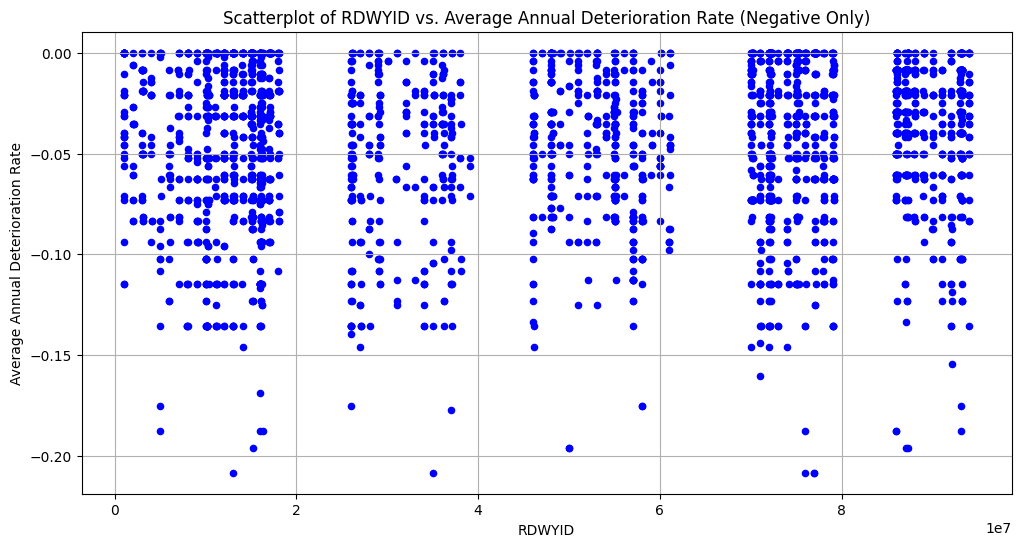

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df_climate' contains the DataFrame with 'RDWYID' and 'average annual deterioration rate' columns
filtered_data = df_climate[df_climate['ANNUAL_DETERIORATION_RATE_x'] <= 0]
# Create a scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data['RDWYID'], filtered_data['ANNUAL_DETERIORATION_RATE_x'], s=20, c='b', marker='o')
plt.title('Scatterplot of RDWYID vs. Average Annual Deterioration Rate (Negative Only)')
plt.xlabel('RDWYID')
plt.ylabel('Average Annual Deterioration Rate')
plt.grid(True)
plt.show()








# Pilot Study Selection

In [ ]:
# Sort the DataFrame by the 'average annual deterioration rate' column in ascending order
df_sorted = df_climate.sort_values(by='ANNUAL_DETERIORATION_RATE_y ', ascending=True)

# Get the 5 cycles with the lowest annual average deterioration rate
lowest_5 = df_sorted.head(5)

# Sort the DataFrame by the 'average annual deterioration rate' column in descending order
df_sorted = df_climate.sort_values(by='ANNUAL_DETERIORATION_RATE_y ', ascending=False)

# Get the 5 cycles with the highest annual average deterioration rate
highest_5 = df_sorted.head(5)

# Display the 5 cycles with the lowest and 5 cycles with the highest annual average deterioration rate
print("5 Cycles with the Lowest Annual Average Deterioration Rate:")
print(lowest_5)

print("5 Cycles with the Highest Annual Average Deterioration Rate:")
print(highest_5)



In [ ]:
# Pilot Study will consist of the cycles with the 5 highest and 5 lowest deterioration rates
# Sort the cleaned data by the deteriorate rate column and  put the

# Sort the DataFrame by the "deterioration_rate" column in ascending order
df_sorted = df.sort_values(by='ANNUAL_DETERIORATION_RATE_y')

# Select the rows with the 5 lowest deterioration rates
lowest_rates = df_sorted.head(5)

# Select the rows with the 5 highest deterioration rates
highest_rates = df_sorted.tail(5)

# Concatenate the highest and lowest rate DataFrames
pilot_study = pd.concat([lowest_rates, highest_rates])

# Reset the index for the combined DataFrame
pilot_study = pilot_study.reset_index(drop=True)